In [1]:
# Import necessary libraries
# pandas for data manipulation and analysis
import pandas as pd
# numpy for numerical operations
import numpy as np
# matplotlib for data visualization
import matplotlib.pyplot as plt
# RandomForestRegressor: Machine learning model used for regression tasks
from sklearn.ensemble import RandomForestRegressor
# Metrics to evaluate the model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
# StandardScaler for feature scaling to normalize input data
from sklearn.preprocessing import StandardScaler
# train_test_split to split data into training and validation sets
from sklearn.model_selection import train_test_split
# matplotlib.dates for formatting datetime ticks in time series plots
import matplotlib.dates as mdates


In [2]:
# Load the training dataset
# Load the testing dataset
# 'parse_dates' ensures that the 'date' column is treated as datetime format
train_df = pd.read_csv("train.csv", parse_dates=["date"])
test_df = pd.read_csv("test.csv", parse_dates=["date"])


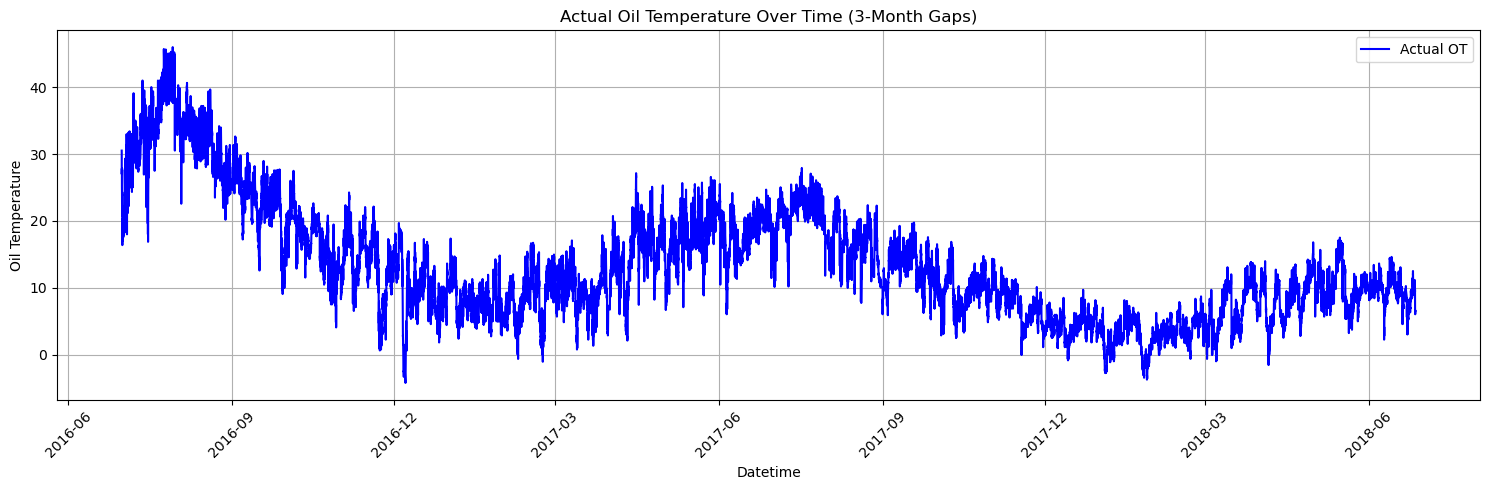

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
plt.plot(train_df['date'], train_df['OT'], color='blue', label='Actual OT')

# Set x-axis ticks at every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.title("Actual Oil Temperature Over Time (3-Month Gaps)")
plt.xlabel("Datetime")
plt.ylabel("Oil Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Display the first 5 rows of the training dataset
print("Train Data - Head:")
print(train_df.head())

# Display the last 5 rows of the training dataset
print("\nTrain Data - Tail:")
print(train_df.tail())

# Display the first 5 rows of the testing dataset
print("\nTest Data - Head:")
print(test_df.head())

# Display the last 5 rows of the testing dataset
print("\nTest Data - Tail:")
print(test_df.tail())


Train Data - Head:
                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401  30.459999
2 2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310  30.038000
3 2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310  27.013000
4 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001

Train Data - Tail:
                     date   HUFL   HULL   MUFL   MULL   LUFL   LULL     OT
69691 2018-06-26 22:45:00  6.832  1.541  4.477  0.284  1.706  0.670  6.191
69692 2018-06-26 23:00:00  8.172  2.009  6.325  0.746  1.736  0.731  6.402
69693 2018-06-26 23:15:00  7.837  2.411  6.254  1.173  1.675  0.670  6.191
69694 2018-06-26 23:30:00  8.038  1.808  6.183  0.782  1.523  0.670  6.261
69695 2018-06-26 23:45:00  6.966  2.076  5.472  0.888  1.645  0.670  6.542

Test Data - Head:
                 date       HUFL    HULL  

In [5]:
# Convert 'date' column to datetime format for both train and test datasets
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Set 'date' as the index to use time-based interpolation
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

# Perform linear interpolation only on numeric columns to handle missing values
train_df.interpolate(method='linear', inplace=True)
test_df.interpolate(method='linear', inplace=True)

# Reset the index back to default after interpolation
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

# Print the count of missing values in each column after interpolation (should be 0)
print("Train Missing:\n", train_df.isnull().sum())
print("Test Missing:\n", test_df.isnull().sum())


Train Missing:
 date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64
Test Missing:
 date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


In [6]:
# Function to extract time-based features from the 'date' column
def extract_time_features(df):
    df["hour"] = df["date"].dt.hour           # Extract the hour from datetime
    df["dayofweek"] = df["date"].dt.dayofweek # Extract the day of the week (0=Monday, 6=Sunday)
    df["month"] = df["date"].dt.month         # Extract the month from datetime
    df["is_weekend"] = df["dayofweek"] >= 5   # Flag weekends (Saturday and Sunday)
    return df

# Apply the function to both training and testing datasets
train_df = extract_time_features(train_df)
test_df = extract_time_features(test_df)


In [7]:
# Create lag features: These represent the value of 'OT' from previous time steps
for lag in [1, 2, 3, 24]:
    train_df[f'OT_lag_{lag}'] = train_df['OT'].shift(lag)  # Shift OT column by 'lag' steps to create new lag feature columns


In [8]:
# Rolling statistics: Capture local trends and variability in OT (Oil Temperature)

# 3-hour rolling mean and standard deviation
train_df['OT_roll_mean_3'] = train_df['OT'].rolling(window=3).mean()  # Mean over past 3 hours
train_df['OT_roll_std_3'] = train_df['OT'].rolling(window=3).std()    # Std deviation over past 3 hours

# 24-hour rolling mean and standard deviation
train_df['OT_roll_mean_24'] = train_df['OT'].rolling(window=24).mean()  # Mean over past 24 hours
train_df['OT_roll_std_24'] = train_df['OT'].rolling(window=24).std()    # Std deviation over past 24 hours


In [9]:
# Define the features (input variables) and target (output variable)
# Features include the historical data (lags), rolling statistics, and time-based features
features = [
    'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL',  # Other features related to the transformer or environment
    'hour', 'dayofweek', 'month', 'is_weekend',        # Time-based features
    'OT_lag_1', 'OT_lag_2', 'OT_lag_3', 'OT_lag_24',   # Lag features to capture past OT values
    'OT_roll_mean_3', 'OT_roll_std_3',                 # 3-hour rolling statistics
    'OT_roll_mean_24', 'OT_roll_std_24'                # 24-hour rolling statistics
]

# Target variable - Oil Temperature (OT) we are predicting
target = 'OT'


In [10]:
# Extract feature matrix (X) and target vector (y)
X = train_df[features]
y = train_df[target]

# Standardize the feature values using StandardScaler
# This ensures each feature contributes equally to the model training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit on X and transform it


In [11]:
# Split the data into training and validation sets (80-20 split)
# We use the first 80% for training and the remaining 20% for validation

split_index = int(0.8 * len(X))  # Calculate the split point

X_train, X_val = X_scaled[:split_index], X_scaled[split_index:]  # Features
y_train, y_val = y[:split_index], y[split_index:]                # Target


In [12]:
# Train the Random Forest Regressor
# n_estimators=100 means the forest has 100 decision trees
# random_state ensures reproducibility

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # Fit the model on training data


RandomForestRegressor(random_state=42)

In [13]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Extract corresponding dates for the validation set
# This will help in plotting actual vs predicted values with correct timestamps
val_dates = train_df.iloc[split_index:]['date']


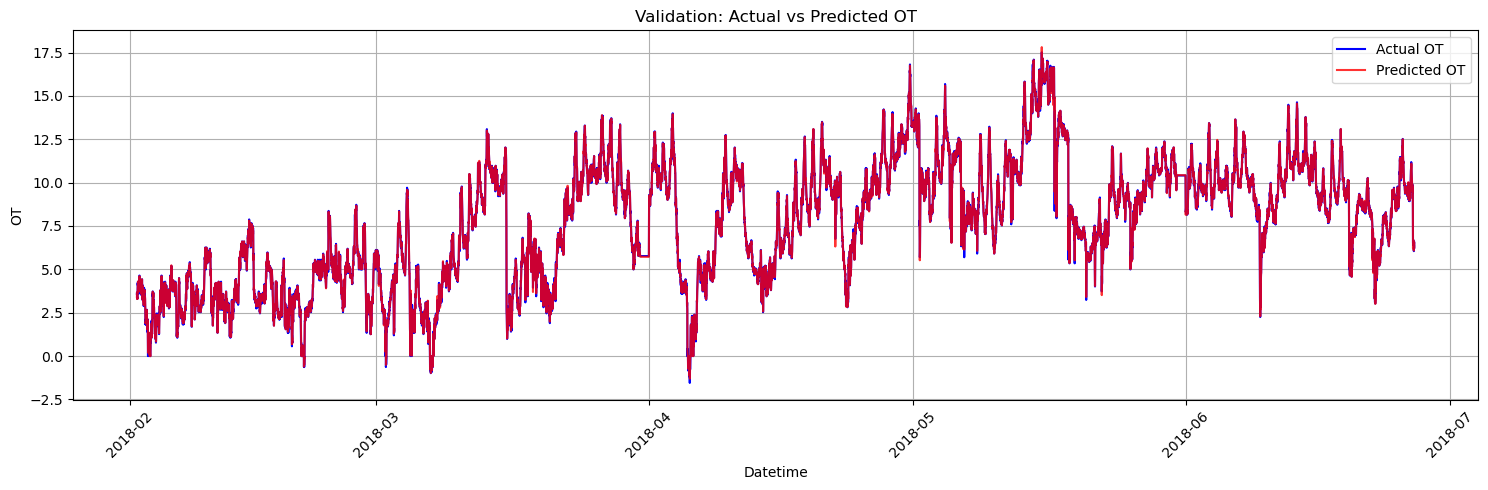

In [14]:
# Extract the corresponding dates for the validation data
val_dates = train_df.iloc[split_index:]['date']  # This was set earlier

# Plot Actual vs Predicted Oil Temperature for the validation set
plt.figure(figsize=(15, 5))

# Plot actual OT values
plt.plot(val_dates, y_val.values, label='Actual OT', color='blue')

# Plot predicted OT values
plt.plot(val_dates, y_pred, label='Predicted OT', color='red', alpha=0.8)

# Set chart title and labels
plt.title("Validation: Actual vs Predicted OT")
plt.xlabel("Datetime")
plt.ylabel("OT")

# Add legend and improve readability
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# Take the last known row from the training data (used as the base for recursive prediction)
last_known = train_df.iloc[-1:].copy()

# Initialize an empty list to store the 24-hour forecast results
forecast_24h = []


In [16]:
# Initialize an empty list to hold forecast results
forecast_24h = []

# Perform 24-hour recursive forecasting
for i in range(24):
    # Select the input features from the latest known data
    X_input = last_known[features]
    
    # Scale the input features
    X_input_scaled = scaler.transform(X_input)
    
    # Make prediction using the trained Random Forest model
    pred = model.predict(X_input_scaled)[0]
    
    # Save the prediction with the corresponding datetime
    forecast_24h.append((last_known["date"].values[0], pred))
    
    # Create a new row for the next hour
    new_row = last_known.copy()
    new_row["date"] = new_row["date"] + pd.Timedelta(hours=1)  # move forward by 1 hour
    new_row["OT"] = pred  # update OT with predicted value

    # Update lag features (shifted values from previous hours)
    for lag in [1, 2, 3]:
        new_row[f"OT_lag_{lag}"] = last_known[f"OT_lag_{lag - 1}"].values if lag > 1 else last_known["OT"].values
    new_row["OT_lag_24"] = last_known["OT"].values  # use 1-hour lag for OT_lag_24 (approximate)

    # Create a temporary dataframe to recalculate rolling statistics
    recent_values = pd.concat([train_df, pd.DataFrame(forecast_24h, columns=["date", "OT"])]).tail(24)
    new_row["OT_roll_mean_3"] = recent_values["OT"].rolling(window=3).mean().iloc[-1]
    new_row["OT_roll_std_3"] = recent_values["OT"].rolling(window=3).std().iloc[-1]
    new_row["OT_roll_mean_24"] = recent_values["OT"].rolling(window=24).mean().iloc[-1]
    new_row["OT_roll_std_24"] = recent_values["OT"].rolling(window=24).std().iloc[-1]

    # Extract time-based features (hour, day of week, etc.)
    new_row = extract_time_features(new_row)

    # Update last_known for next iteration
    last_known = new_row

# Convert results to a DataFrame for plotting and analysis
forecast_df = pd.DataFrame(forecast_24h, columns=["date", "OT_Predicted"])


In [17]:
print("Last datetime in training data:", train_df['date'].max())
print("First datetime in 24h forecast:", forecast_df['date'].min())
print("Last datetime in 24h forecast:", forecast_df['date'].max())



Last datetime in training data: 2018-06-26 23:45:00
First datetime in 24h forecast: 2018-06-26 23:45:00
Last datetime in 24h forecast: 2018-06-27 22:45:00


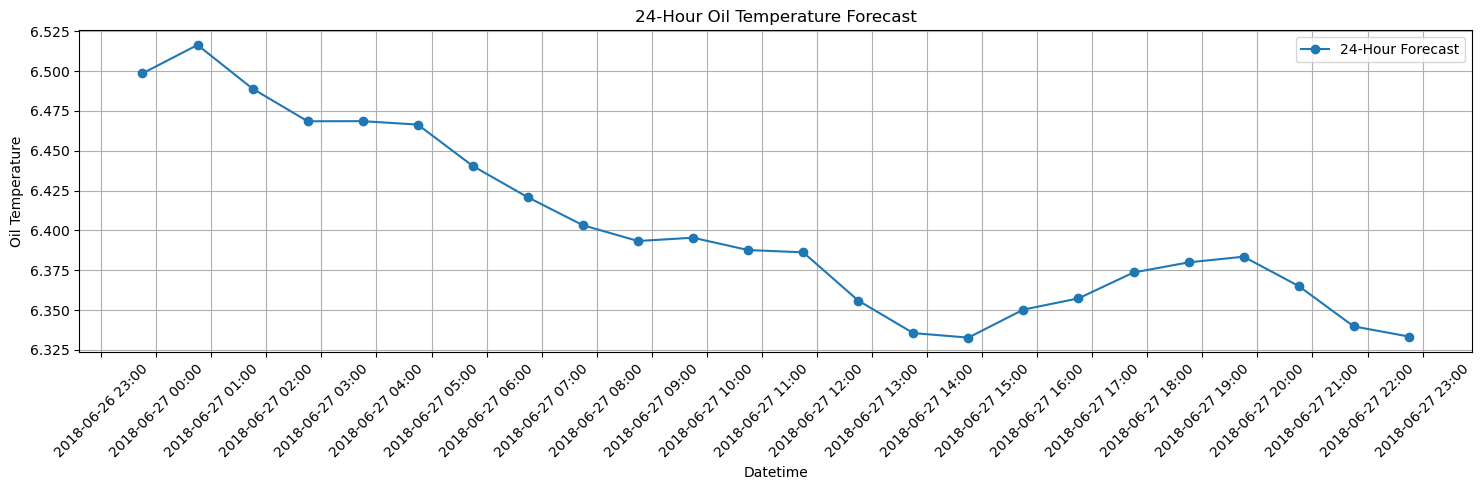

''

In [18]:
# Plotting the 24-hour oil temperature forecast
plt.figure(figsize=(15, 5))  # Set figure size

# Plot the predicted values with datetime on x-axis
plt.plot(forecast_df['date'], forecast_df['OT_Predicted'], marker='o', linestyle='-', label="24-Hour Forecast")

# Set x-axis major ticks to every 1 hour
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Format the x-axis tick labels to show date and hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add plot title and axis labels
plt.title("24-Hour Oil Temperature Forecast")
plt.xlabel("Datetime")
plt.ylabel("Oil Temperature")

# Add legend and grid
plt.legend()
plt.grid(True)

# Ensure layout fits well
plt.tight_layout()

# Display the plot
plt.show()
""

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_val_pred = model.predict(X_val)

# Evaluation Metrics
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Validation MAE: 0.05
Validation RMSE: 0.09
R² Score: 1.00
